In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

## Sample Prep

### Define sample types

In [4]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Project ID':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [5]:
from dutils import Experiment, train_test_split_case
exp = Experiment(samples_dir='../../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv',
                 hierarchy=hierarchy,
                 cases='Case ID',
                 min_samples=20)
exp.holdout(holdout=['TCGA-SKCM:Metastatic'])

In [6]:
samples = pd.read_csv('../../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
samples.head()

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type
0,754774dd-77e1-4cf5-b9b5-3afad9f41410,999edb9e-8a45-4115-84d5-fca75dcfa639.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-E2-A1IG,TCGA-E2-A1IG-01A,Primary Tumor
1,8bf102b9-baf7-4749-bcd0-eca25f600722,23393a6a-bfbc-4dec-9ab5-e78a487a095f.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-EW-A1J5,TCGA-EW-A1J5-01A,Primary Tumor
2,5bf7609e-68cb-4ddb-8f05-ee1d4f92cf9b,4a9bb3fd-4e75-4585-82f7-7254889b9838.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-BRCA,TCGA-AR-A1AU,TCGA-AR-A1AU-01A,Primary Tumor
3,10a40ceb-080c-4758-97f9-1a262e2639ed,9858d286-1b96-4414-bd09-d73dc6f1c79e.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-DB-A64R,TCGA-DB-A64R-01A,Primary Tumor
4,2600ef39-0bdf-4e10-9fdf-e3dbed7b5383,f7182de7-067e-467b-af88-790ad3e63eec.FPKM.txt.gz,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-P5-A77X,TCGA-P5-A77X-01A,Primary Tumor


In [7]:
with pd.option_context('display.max_rows', None):
    bar = samples.groupby(['Project ID', 'Sample Type']).size().reset_index()

In [8]:
bar[bar['Sample Type']=='Metastatic'].nlargest(5, columns=0)
bar[bar['Sample Type'] == 'Recurrent Tumor'].nlargest(5, columns=0)

,Project ID,Sample Type,0
57,TCGA-SKCM,Metastatic,364
3,TCGA-BRCA,Metastatic,7
64,TCGA-THCA,Metastatic,7
6,TCGA-CESC,Metastatic,2
11,TCGA-COAD,Metastatic,1


,Project ID,Sample Type,0
31,TCGA-LGG,Recurrent Tumor,18
20,TCGA-GBM,Recurrent Tumor,13
42,TCGA-OV,Recurrent Tumor,5
33,TCGA-LIHC,Recurrent Tumor,3
36,TCGA-LUAD,Recurrent Tumor,2


In [9]:
exp.meta_dict

{0: 'TCGA-BRCA:Primary Tumor',
 1: 'TCGA-BRCA:Solid Tissue Normal',
 2: 'TCGA-KIRC:Primary Tumor',
 3: 'TCGA-KIRC:Solid Tissue Normal',
 4: 'TCGA-LUAD:Primary Tumor',
 5: 'TCGA-LUAD:Solid Tissue Normal',
 6: 'TCGA-PRAD:Primary Tumor',
 7: 'TCGA-PRAD:Solid Tissue Normal',
 8: 'TCGA-SKCM:Metastatic',
 9: 'TCGA-SKCM:Primary Tumor',
 10: 'TCGA-THCA:Primary Tumor',
 11: 'TCGA-THCA:Solid Tissue Normal'}

## Dataset Prep

Need to ensure test set has health/diseased samples matched for each case

In [10]:
exp.samples['meta'].value_counts()
exp.holdout_samples['meta'].value_counts()

TCGA-BRCA:Primary Tumor          1087
TCGA-LUAD:Primary Tumor           528
TCGA-KIRC:Primary Tumor           483
TCGA-PRAD:Primary Tumor           466
TCGA-THCA:Primary Tumor           445
TCGA-BRCA:Solid Tissue Normal     112
TCGA-SKCM:Primary Tumor           103
TCGA-KIRC:Solid Tissue Normal      70
TCGA-LUAD:Solid Tissue Normal      58
TCGA-THCA:Solid Tissue Normal      53
TCGA-PRAD:Solid Tissue Normal      50
TCGA-SKCM:Metastatic                0
Name: meta, dtype: int64

TCGA-SKCM:Metastatic             364
TCGA-THCA:Solid Tissue Normal      0
TCGA-THCA:Primary Tumor            0
TCGA-SKCM:Primary Tumor            0
TCGA-PRAD:Solid Tissue Normal      0
TCGA-PRAD:Primary Tumor            0
TCGA-LUAD:Solid Tissue Normal      0
TCGA-LUAD:Primary Tumor            0
TCGA-KIRC:Solid Tissue Normal      0
TCGA-KIRC:Primary Tumor            0
TCGA-BRCA:Solid Tissue Normal      0
TCGA-BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler

target = 'meta'

train, test = train_test_split_case(exp.samples, cases='Case ID')
# stratification is not quite perfect but close
# in order to preserve matched samples for each case together
# in train or test set
case_counts = exp.samples[target].value_counts()
train[target].value_counts()[case_counts.index.to_numpy()] / case_counts
test[target].value_counts()[case_counts.index.to_numpy()] / case_counts

TCGA-BRCA:Primary Tumor          0.819687
TCGA-LUAD:Primary Tumor          0.825758
TCGA-KIRC:Primary Tumor          0.763975
TCGA-PRAD:Primary Tumor          0.793991
TCGA-THCA:Primary Tumor          0.779775
TCGA-BRCA:Solid Tissue Normal    0.892857
TCGA-SKCM:Primary Tumor          0.786408
TCGA-KIRC:Solid Tissue Normal    0.714286
TCGA-LUAD:Solid Tissue Normal    0.827586
TCGA-THCA:Solid Tissue Normal    0.754717
TCGA-PRAD:Solid Tissue Normal    0.740000
TCGA-SKCM:Metastatic                  NaN
Name: meta, dtype: float64

TCGA-BRCA:Primary Tumor          0.180313
TCGA-LUAD:Primary Tumor          0.174242
TCGA-KIRC:Primary Tumor          0.236025
TCGA-PRAD:Primary Tumor          0.206009
TCGA-THCA:Primary Tumor          0.220225
TCGA-BRCA:Solid Tissue Normal    0.107143
TCGA-SKCM:Primary Tumor          0.213592
TCGA-KIRC:Solid Tissue Normal    0.285714
TCGA-LUAD:Solid Tissue Normal    0.172414
TCGA-THCA:Solid Tissue Normal    0.245283
TCGA-PRAD:Solid Tissue Normal    0.260000
TCGA-SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [12]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))


Cuda is available: True


In [13]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../../data/TCGA/rna-seq_pan/"

train_dataset = TCGA(root_dir, samples=train, meta_dict=exp.meta_dict, train=True, target=target, log=True)
train_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

test_dataset = TCGA(root_dir, samples=test, meta_dict=exp.meta_dict, train=False, target=target, log=True)
test_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

In [14]:
np.array_equal(train_dataset.data.columns, test_dataset.data.columns)

True

In [15]:
scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

In [16]:
train_dataset.data.shape
test_dataset.data.shape

# Still required in order to feed single samples for embedding extraction
batch_size = 1
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

(2769, 19577)

(686, 19577)

## Siamese Network

In [19]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss, TripletLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features, 2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19577, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [20]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2769 (0%)]	Loss: 0.185653
Train: [696/2769 (25%)]	Loss: 0.106880
Train: [1392/2769 (50%)]	Loss: 0.055256
Train: [2088/2769 (75%)]	Loss: 0.059931
Epoch: 1/10. Train set: Average loss: 0.0651
Epoch: 1/10. Validation set: Average loss: 0.0509
Train: [0/2769 (0%)]	Loss: 0.019154
Train: [696/2769 (25%)]	Loss: 0.030436
Train: [1392/2769 (50%)]	Loss: 0.034010
Train: [2088/2769 (75%)]	Loss: 0.020982
Epoch: 2/10. Train set: Average loss: 0.0257
Epoch: 2/10. Validation set: Average loss: 0.0285
Train: [0/2769 (0%)]	Loss: 0.019647
Train: [696/2769 (25%)]	Loss: 0.014786
Train: [1392/2769 (50%)]	Loss: 0.020531
Train: [2088/2769 (75%)]	Loss: 0.022089
Epoch: 3/10. Train set: Average loss: 0.0195
Epoch: 3/10. Validation set: Average loss: 0.0394
Train: [0/2769 (0%)]	Loss: 0.011906
Train: [696/2769 (25%)]	Loss: 0.028906
Train: [1392/2769 (50%)]	Loss: 0.018791
Train: [2088/2769 (75%)]	Loss: 0.061195
Epoch: 4/10. Train set: Average loss: 0.0462
Epoch: 4/10. Validation set: Average loss: 0.0829


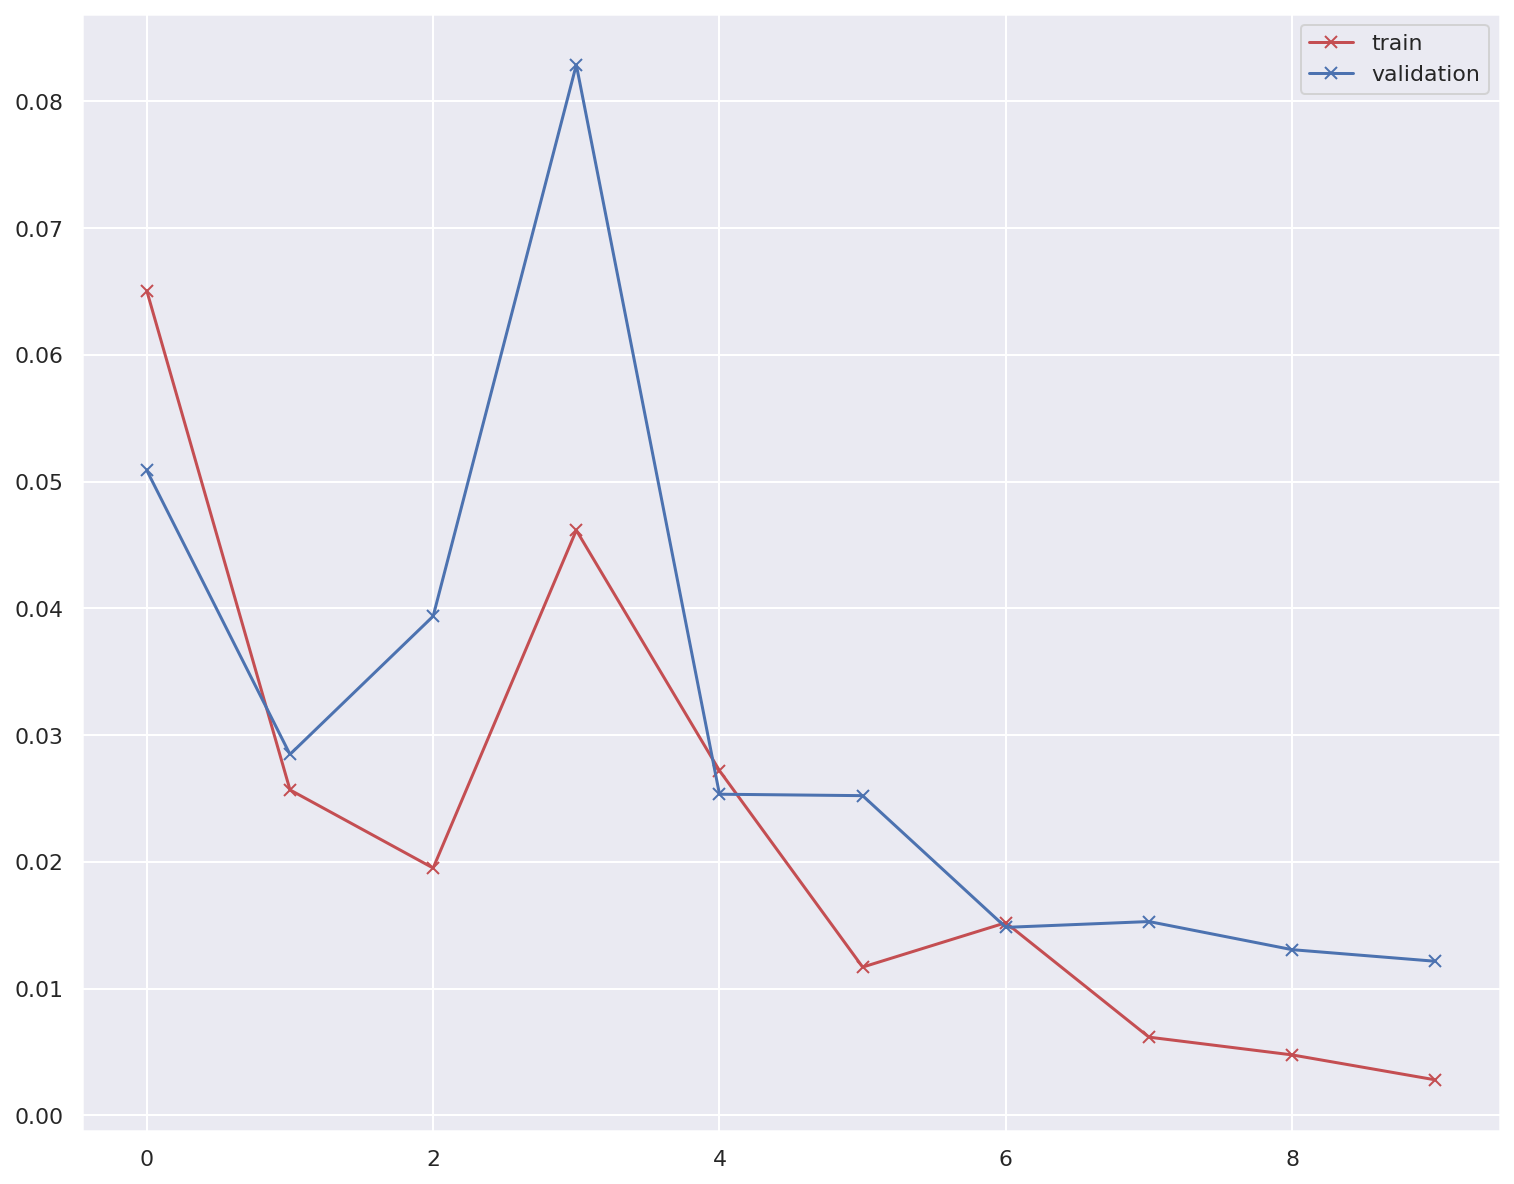

In [21]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

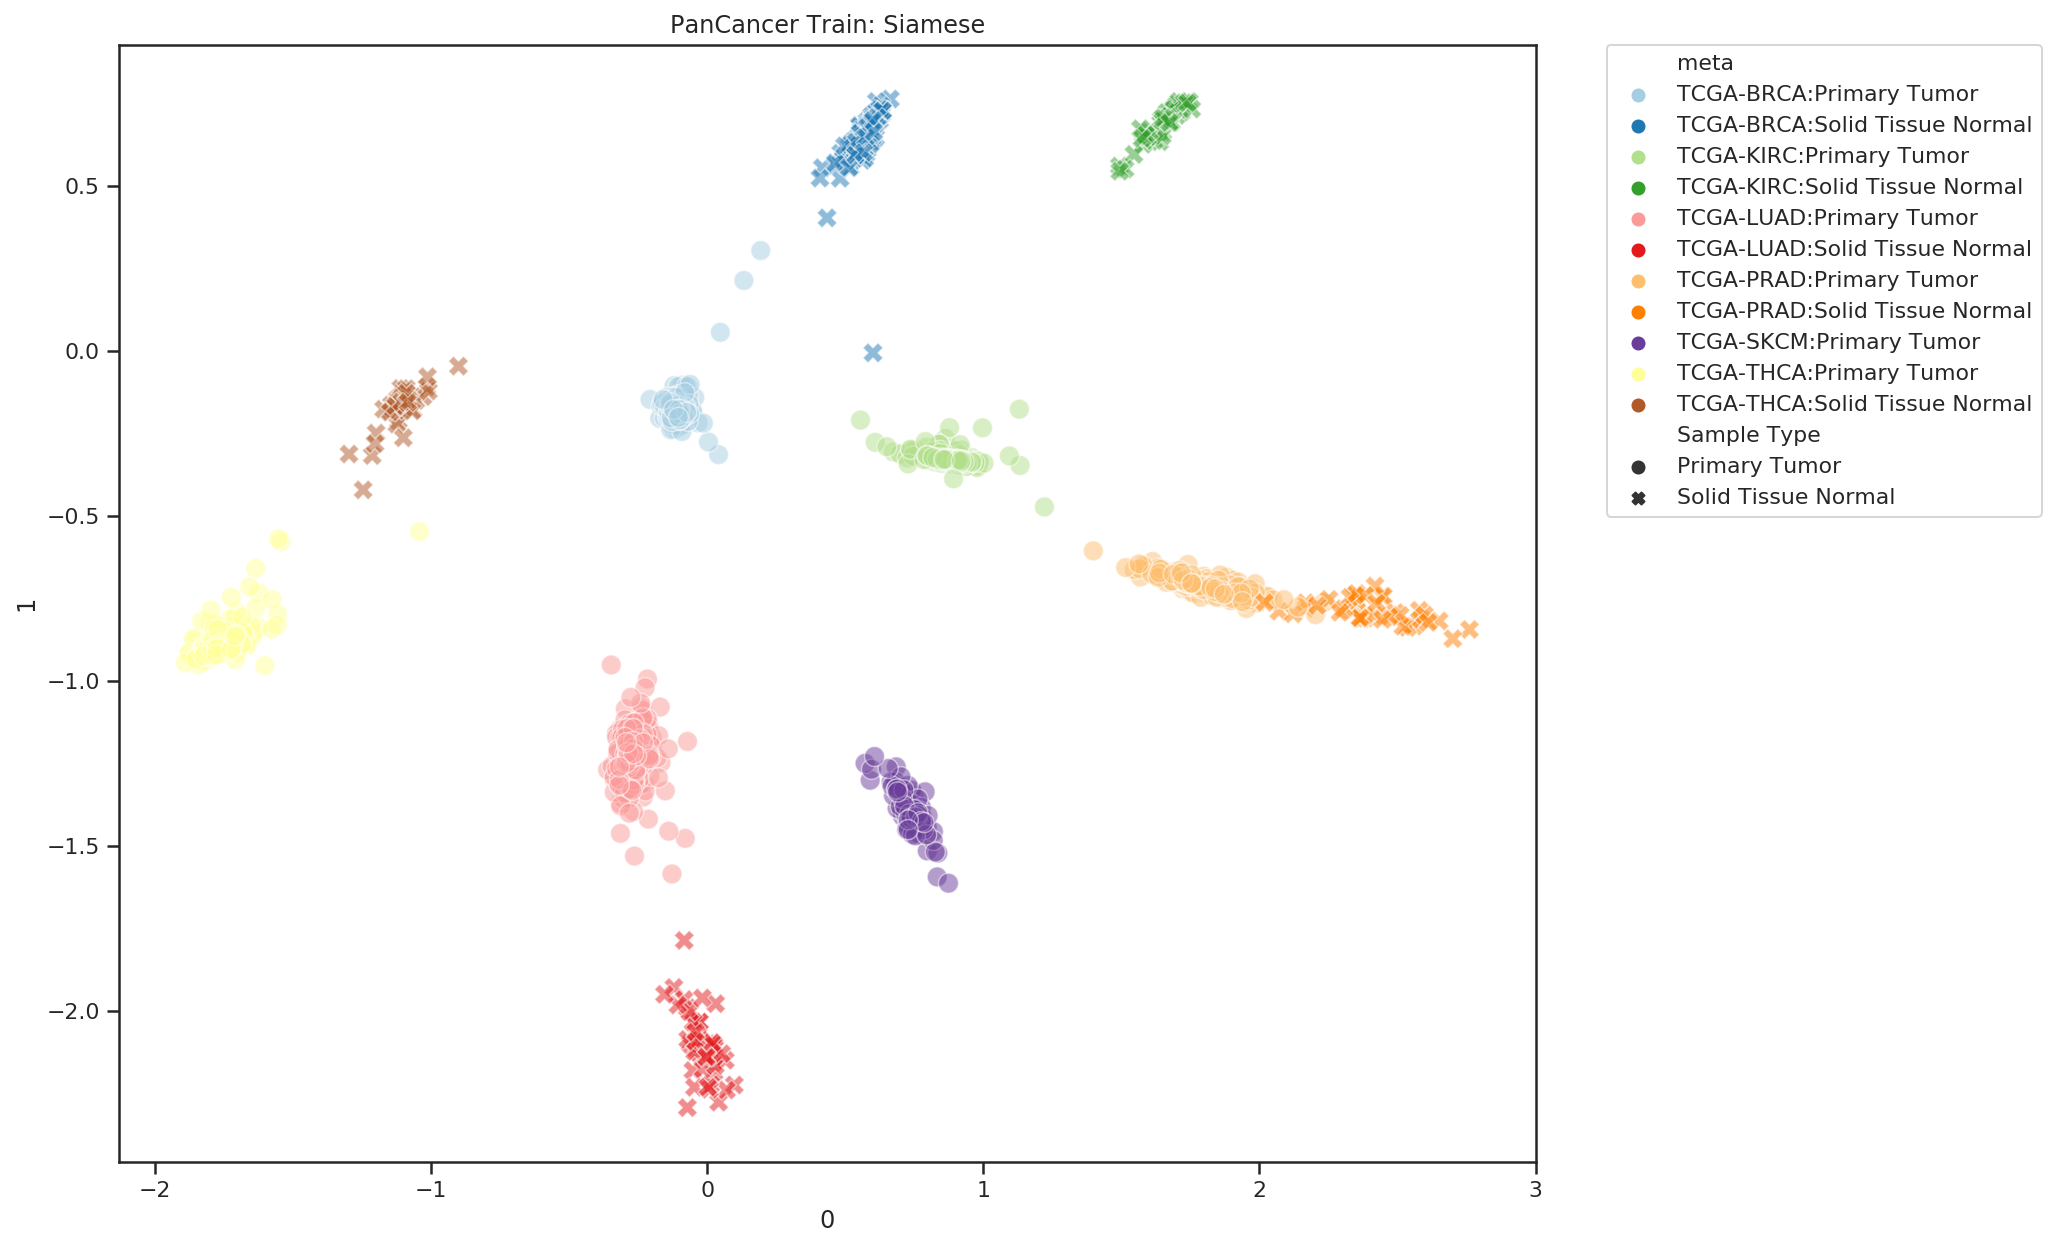

In [22]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.meta_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

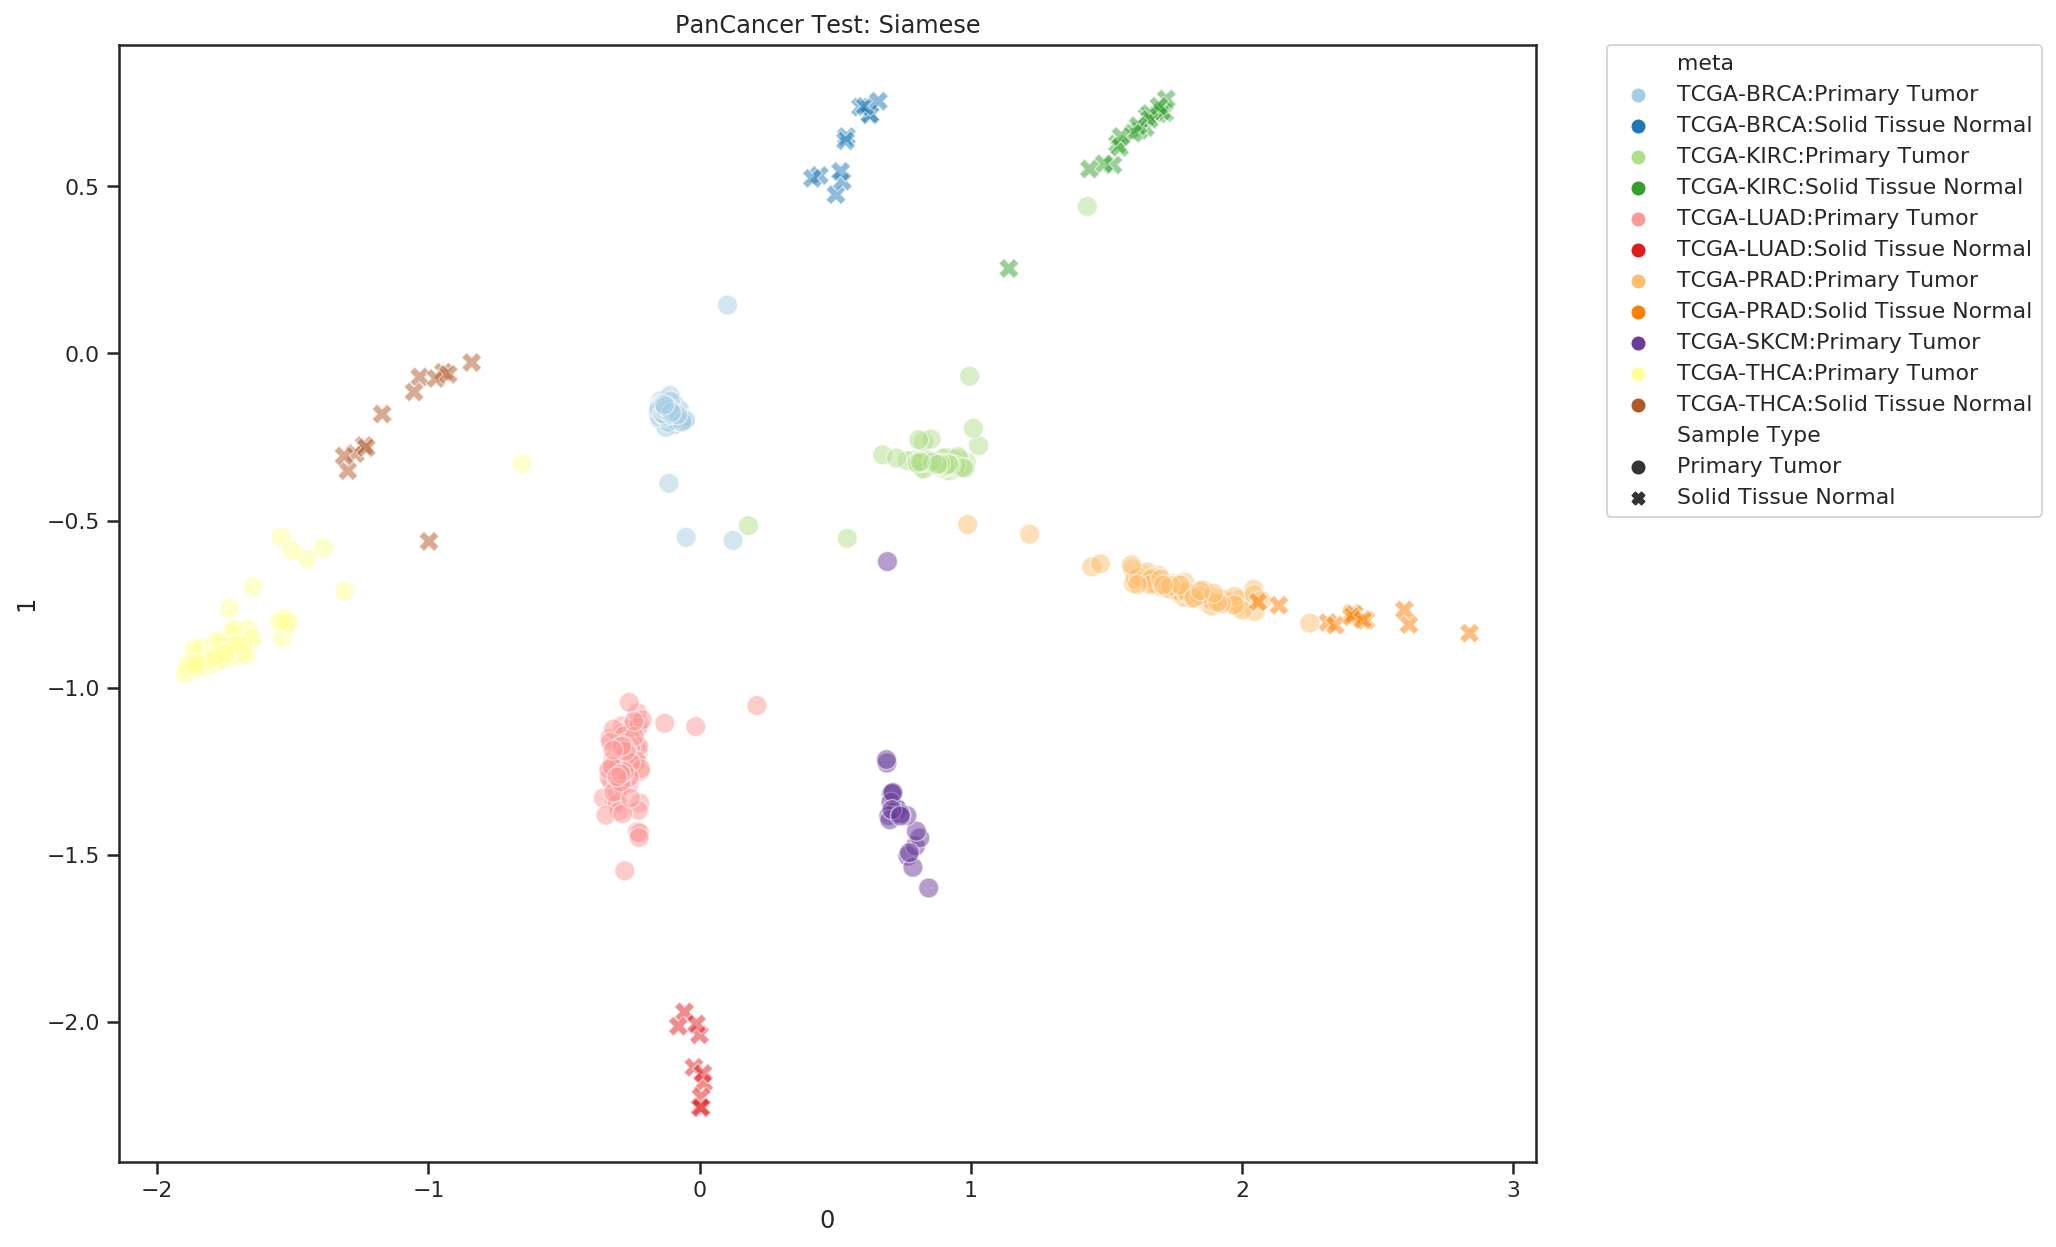

In [23]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.meta_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Save Model

In [53]:
save = False
if save:
    torch.save(model.state_dict(), "../../data/TCGA/models/220_seminar_results.pt")

## Kmeans Cluster and NMI Evaluation

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_mutual_info_score as aNMI

In [55]:
n_clusters = len(siamese_test_dataset.meta_dict) - len(exp.holdout)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
siamese_clusters = kmeans.fit_predict(val_embeddings_baseline)

In [56]:
aNMI(siamese_clusters, val_labels_baseline)

0.9361293936405841

## Project Metastatic SKCM

In [57]:
proj_dataset = TCGA(root_dir, samples=exp.holdout_samples, meta_dict=exp.meta_dict, train=False, target=target, log=True)
proj_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

In [58]:
proj_dataset.data = pd.DataFrame(scaler.transform(proj_dataset.data),
                                 index=proj_dataset.data.index,
                                 columns=proj_dataset.data.columns)

In [59]:
# Still required in order to feed single samples for embedding extraction
batch_size = 1
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
proj_loader = torch.utils.data.DataLoader(proj_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [60]:
proj_embeddings_baseline, proj_labels_baseline = vis.extract_embeddings(proj_loader, model)

In [61]:
comb_embeddings = np.concatenate([val_embeddings_baseline, proj_embeddings_baseline], axis=0)
comb_labels = np.concatenate([val_labels_baseline, proj_labels_baseline], axis=0)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

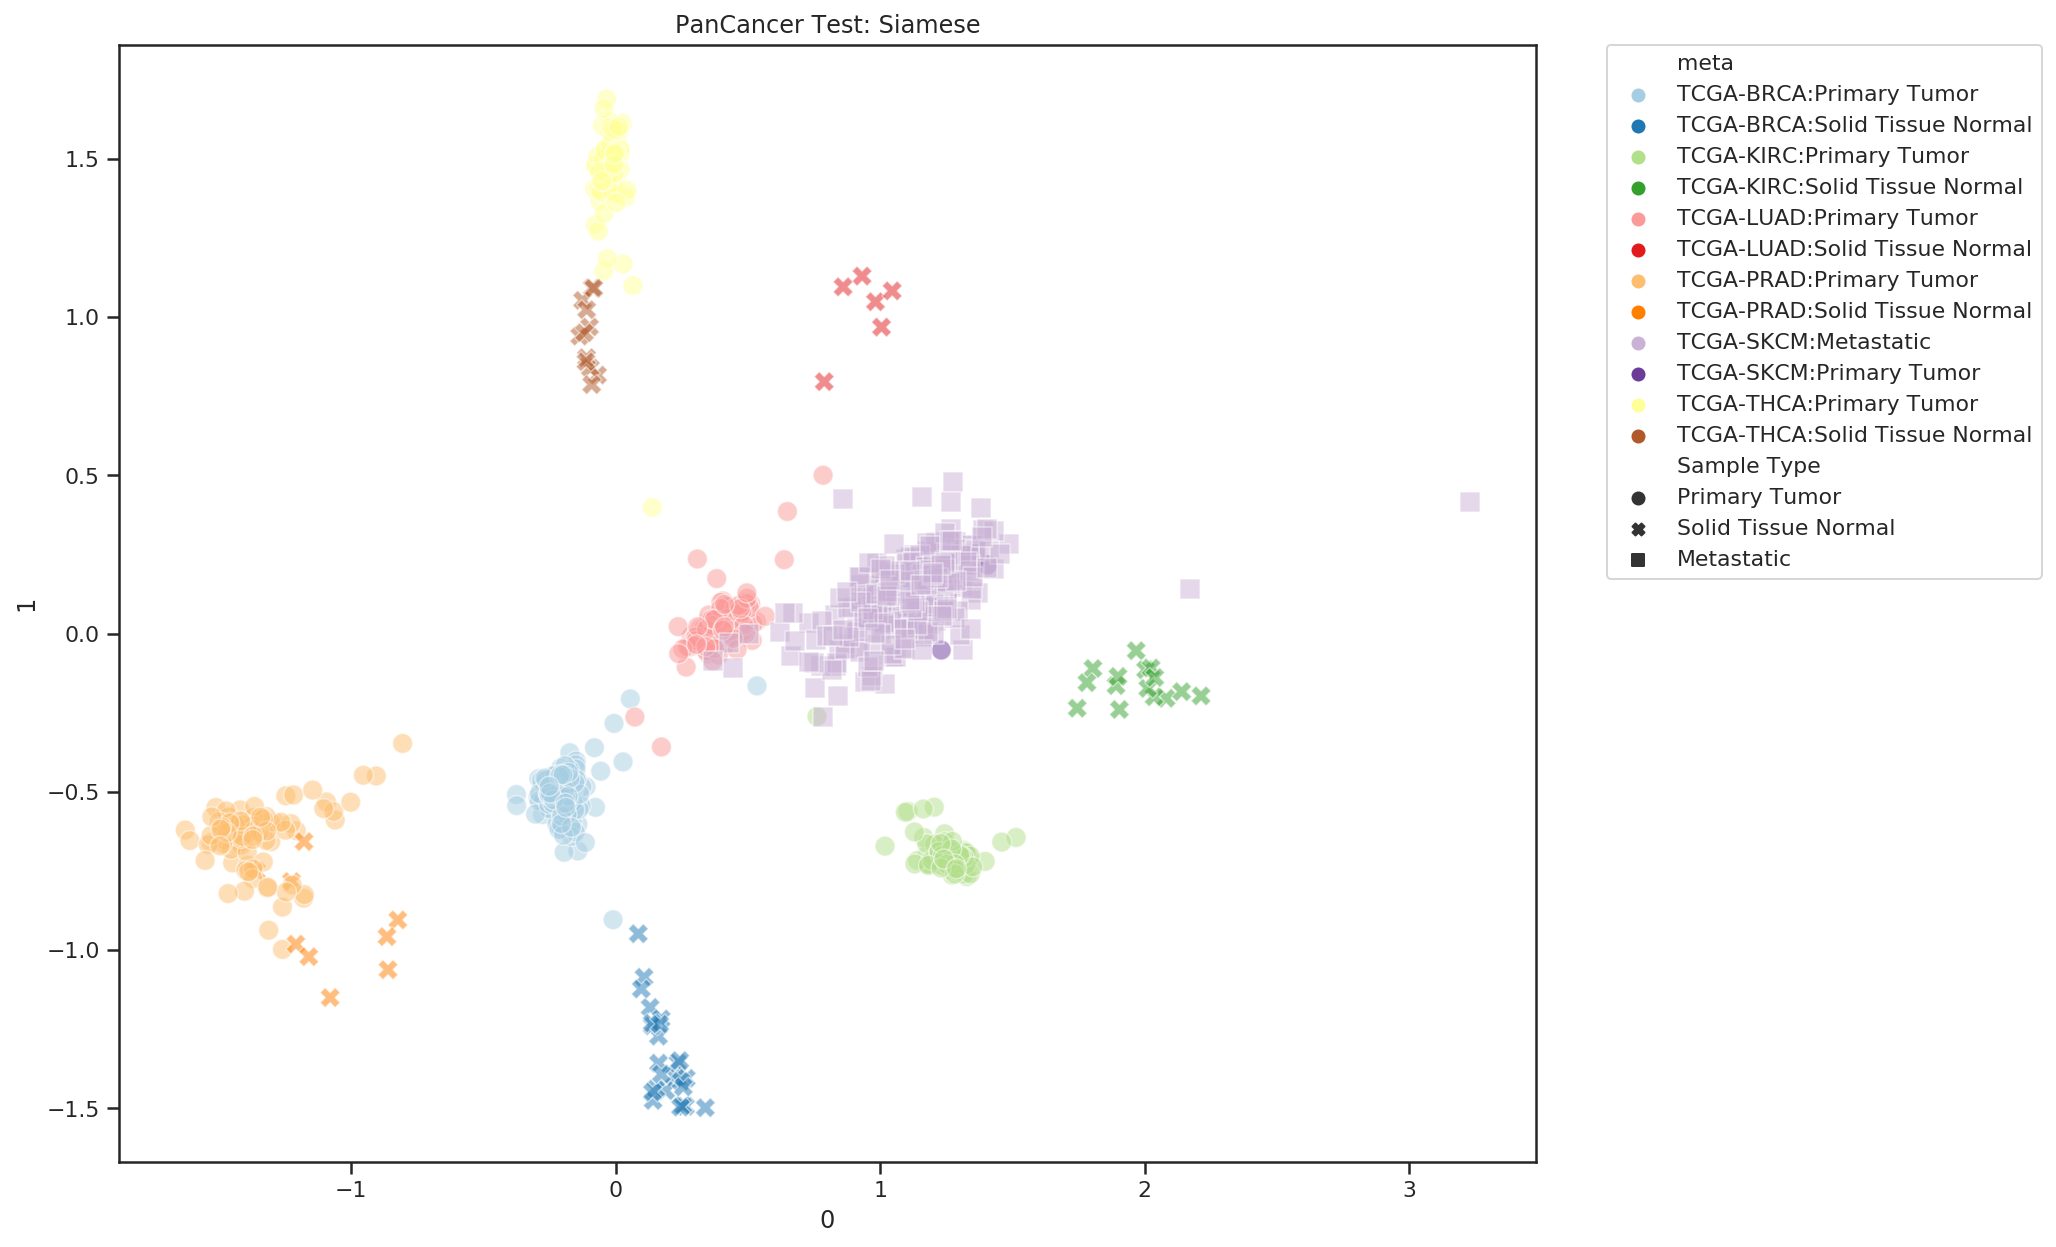

In [136]:
vis.sns_plot_embeddings(comb_embeddings, comb_labels, exp.meta_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## SKCM Clinical Info

In [167]:
skcm_clinical = pd.read_csv("../../data/TCGA/clinical/skcm/https:/api.gdc.cancer.gov/data/58cbbc07-5ec4-47c7-9295-11ccbf7693f4/nationwidechildrens.org_clinical_patient_skcm.txt", 
                            sep="\t")
# remove extra header
skcm_clinical = skcm_clinical.loc[2:, :].reset_index(drop=True)
skcm_clinical.shape

(470, 65)

In [168]:
skcm_clinical.head()

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,birth_days_to,gender,height_cm_at_diagnosis,weight_kg_at_diagnosis,race,ethnicity,history_other_malignancy,history_neoadjuvant_treatment,tumor_status,vital_status,last_contact_days_to,death_days_to,primary_melanoma_known_dx,primary_multiple_at_dx,primary_at_dx_count,primary_location,breslow_thickness_at_diagnosis,clark_level_at_diagnosis,primary_melanoma_tumor_ulceration,primary_melanoma_mitotic_rate,radiation_therapy_to_primary,initial_pathologic_dx_year,age_at_diagnosis,ajcc_staging_edition,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,ldh_level,ajcc_pathologic_tumor_stage,submitted_tumor_dx_days_to,submitted_tumor_site,metastatic_tumor_site,primary_melanoma_skin_type,prior_radiation_therapy,history_neoadjuvant_treatment.1,history_neoadjuvant_tx_type,ifn_tx_90_days_prior_to_resection,radiation_treatment_adjuvant,pharmaceutical_tx_adjuvant,new_tumor_event_dx_indicator,new_tumor_event_prior_to_bcr_tumor,melanoma_primary_count,clinical_M,clinical_N,clinical_T,clinical_stage,days_to_initial_pathologic_diagnosis,days_to_patient_progression_free,days_to_tumor_progression,disease_code,extranodal_involvement,icd_10,icd_o_3_histology,icd_o_3_site,informed_consent_verified,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site_other
0,5564E6A7-2195-4B0D-994E-B0617B58E889,TCGA-3N-A9WB,2014-5-29,YES,NO,-26176,MALE,175,78,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Dead,[Not Available],518,YES,NO,[Not Available],Distant Metastasis,0.7,III,NO,2,NO,2012,71,7th,T1a,NX,M0,[Not Available],Stage IA,426,Trunk,Left Flank,Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.5,8720/3,C44.5,YES,A9WB,[Not Available],[Not Available],3N,[Not Applicable]
1,551E071A-C290-4B48-9000-F64C2A44DFB7,TCGA-3N-A9WC,2014-5-29,YES,NO,-30286,MALE,183,68,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Alive,1856,[Not Applicable],YES,NO,1,Regional Lymph Node,1.8,IV,YES,4,NO,2009,82,6th,T2b,NX,M0,[Not Available],Stage IIA,1644,Trunk,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C77.3,8720/3,C77.3,YES,A9WC,[Not Available],[Not Available],3N,[Not Applicable]
2,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,TCGA-3N-A9WD,2014-5-29,YES,NO,-30163,MALE,183,116,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Dead,[Not Available],395,YES,NO,1,Regional Lymph Node,1.25,III,NO,4,NO,2013,82,7th,T2a,N1a,M0,[Not Evaluated],Stage IIIA,183,Other Specify,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],YES,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C77.0,8720/3,C77.0,YES,A9WD,[Not Available],[Not Available],3N,Posterior Ear
3,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,TCGA-BF-A1PU,2013-4-25,YES,NO,-17025,FEMALE,160,58,WHITE,[Unknown],No,No,TUMOR FREE,Alive,387,[Not Applicable],YES,NO,1,Primary Tumor,13,III,YES,[Not Available],NO,2010,46,7th,T4b,N0,M0,[Not Available],Stage IIC,0,Extremities,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.9,8720/3,C44.9,YES,A1PU,[Not Available],[Not Available],BF,[Not Applicable]
4,EFF78AF6-0F68-49B9-866B-0D511606F2B1,TCGA-BF-A1PV,2013-4-25,YES,NO,-27124,FEMALE,160,70,WHITE,[Unknown],No,No,TUMOR FREE,Alive,14,[Not Applicable],YES,NO,1,Primary Tumor,9,IV,YES,[Not Available],NO,2010,74,7th,T4b,N0,M0,[Not Available],Stage IIC,0,Trunk,[Not Available],Non-glabrous skin,NO,NO,[Not Available],[Not

In [174]:
metastat_cases = exp.holdout_samples['Case ID'].unique()

In [176]:
skcm_clinical.shape
skcm_clinical = skcm_clinical[skcm_clinical['bcr_patient_barcode'].isin(metastat_cases)]


(470, 65)

In [177]:
skcm_clinical['primary_location'].value_counts()
skcm_clinical['primary_melanoma_known_dx'].value_counts()

Regional Lymph Node                                                                         219
Regional Cutaneous or Subcutaneous Tissue (includes satellite and in-transit metastasis)     72
Distant Metastasis                                                                           68
Primary Tumor                                                                                 3
[Not Available]                                                                               1
[Discrepancy]                                                                                 1
Name: primary_location, dtype: int64

YES    317
NO      47
Name: primary_melanoma_known_dx, dtype: int64

In [178]:
skcm_clinical[skcm_clinical['primary_location']=='Distant Metastasis']

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,birth_days_to,gender,height_cm_at_diagnosis,weight_kg_at_diagnosis,race,ethnicity,history_other_malignancy,history_neoadjuvant_treatment,tumor_status,vital_status,last_contact_days_to,death_days_to,primary_melanoma_known_dx,primary_multiple_at_dx,primary_at_dx_count,primary_location,breslow_thickness_at_diagnosis,clark_level_at_diagnosis,primary_melanoma_tumor_ulceration,primary_melanoma_mitotic_rate,radiation_therapy_to_primary,initial_pathologic_dx_year,age_at_diagnosis,ajcc_staging_edition,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,ldh_level,ajcc_pathologic_tumor_stage,submitted_tumor_dx_days_to,submitted_tumor_site,metastatic_tumor_site,primary_melanoma_skin_type,prior_radiation_therapy,history_neoadjuvant_treatment.1,history_neoadjuvant_tx_type,ifn_tx_90_days_prior_to_resection,radiation_treatment_adjuvant,pharmaceutical_tx_adjuvant,new_tumor_event_dx_indicator,new_tumor_event_prior_to_bcr_tumor,melanoma_primary_count,clinical_M,clinical_N,clinical_T,clinical_stage,days_to_initial_pathologic_diagnosis,days_to_patient_progression_free,days_to_tumor_progression,disease_code,extranodal_involvement,icd_10,icd_o_3_histology,icd_o_3_site,informed_consent_verified,patient_id,project_code,stage_other,tissue_source_site,tumor_tissue_site_other
0,5564E6A7-2195-4B0D-994E-B0617B58E889,TCGA-3N-A9WB,2014-5-29,YES,NO,-26176,MALE,175,78,WHITE,NOT HISPANIC OR LATINO,No,No,WITH TUMOR,Dead,[Not Available],518,YES,NO,[Not Available],Distant Metastasis,0.7,III,NO,2,NO,2012,71,7th,T1a,NX,M0,[Not Available],Stage IA,426,Trunk,Left Flank,Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,NO,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.5,8720/3,C44.5,YES,A9WB,[Not Available],[Not Available],3N,[Not Applicable]
46,C58638ED-A38C-4494-A41E-6EE5283A7A59,TCGA-D3-A2JF,2012-10-10,NO,YES,-27255,MALE,170,80,WHITE,NOT HISPANIC OR LATINO,Yes,No,TUMOR FREE,Alive,1483,[Not Applicable],YES,NO,[Not Available],Distant Metastasis,0.28,III,NO,0,NO,2008,74,7th,T1a,N0,M0,[Not Available],Stage IA,544,Extremities|Trunk,"Left arm, soft tissue",Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,YES,1|1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C49.1,8720/3,C49.1,YES,A2JF,[Not Available],[Not Available],D3,[Not Applicable]|[Not Applicable]
80,854466BF-B943-4ACB-B4F1-6B285CB813E3,TCGA-D3-A5GO,2013-5-10,NO,YES,-22287,MALE,169,83,WHITE,NOT HISPANIC OR LATINO,No,No,TUMOR FREE,Alive,4195,[Not Applicable],YES,NO,[Not Available],Distant Metastasis,4.3,V,[Unknown],[Not Available],NO,2001,61,7th,T4,N0,M0,[Not Available],Stage II,2739,Head and Neck,Soft tissue of right upper arm,Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,YES,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C44.6,8720/3,C44.6,YES,A5GO,[Not Available],[Not Available],D3,[Not Applicable]
90,42FB358C-CC9B-4963-9D16-4A7AA915002A,TCGA-D3-A8GJ,2013-12-17,NO,YES,-6684,MALE,192,85,WHITE,NOT HISPANIC OR LATINO,No,No,TUMOR FREE,Alive,6965,[Not Applicable],YES,NO,[Not Available],Distant Metastasis,2.4,III,[Unknown],[Not Available],NO,1994,18,7th,T3,N0,M0,[Not Available],Stage II,2632,Head and Neck,Small Intestine,Non-glabrous skin,NO,NO,[Not Available],[Not Available],NO,NO,YES,YES,1,[Not Applicable],[Not Applicable],[Not Applicable],[Not Applicable],0,[Not Available],[Not Available],[Not Available],[Not Applicable],C17.9,8720/3,C17.9,YES,A8GJ,[Not Available],[Not Available],D3,[Not Applicable]
91,6EC931E1-7A6F-47A8-8B30-F37271A50881,TCGA-D3-A8GK,2013-12-19,NO,YES,-16569,MALE,178,80,WHITE,NOT HISPANIC OR LATINO,No,No,TUMOR FREE,Alive,4757,[Not Applicable],YES,N

In [99]:
#skcm_metas_dist = skcm_clinical[skcm_clinical['primary_location'] == 'Distant Metastasis']
skcm_metas_dist = skcm_clinical[skcm_clinical['metastatic_tumor_site'] == 'Lung']
skcm_metas_dist.shape

(5, 65)

In [100]:
bool_skcm_metas_dist = exp.holdout_samples['Case ID'].isin(skcm_metas_dist['bcr_patient_barcode'])
bool_skcm_metas_dist.sum()

5

Text(0.5, 1.0, 'PanCancer Metastatic: Siamese')

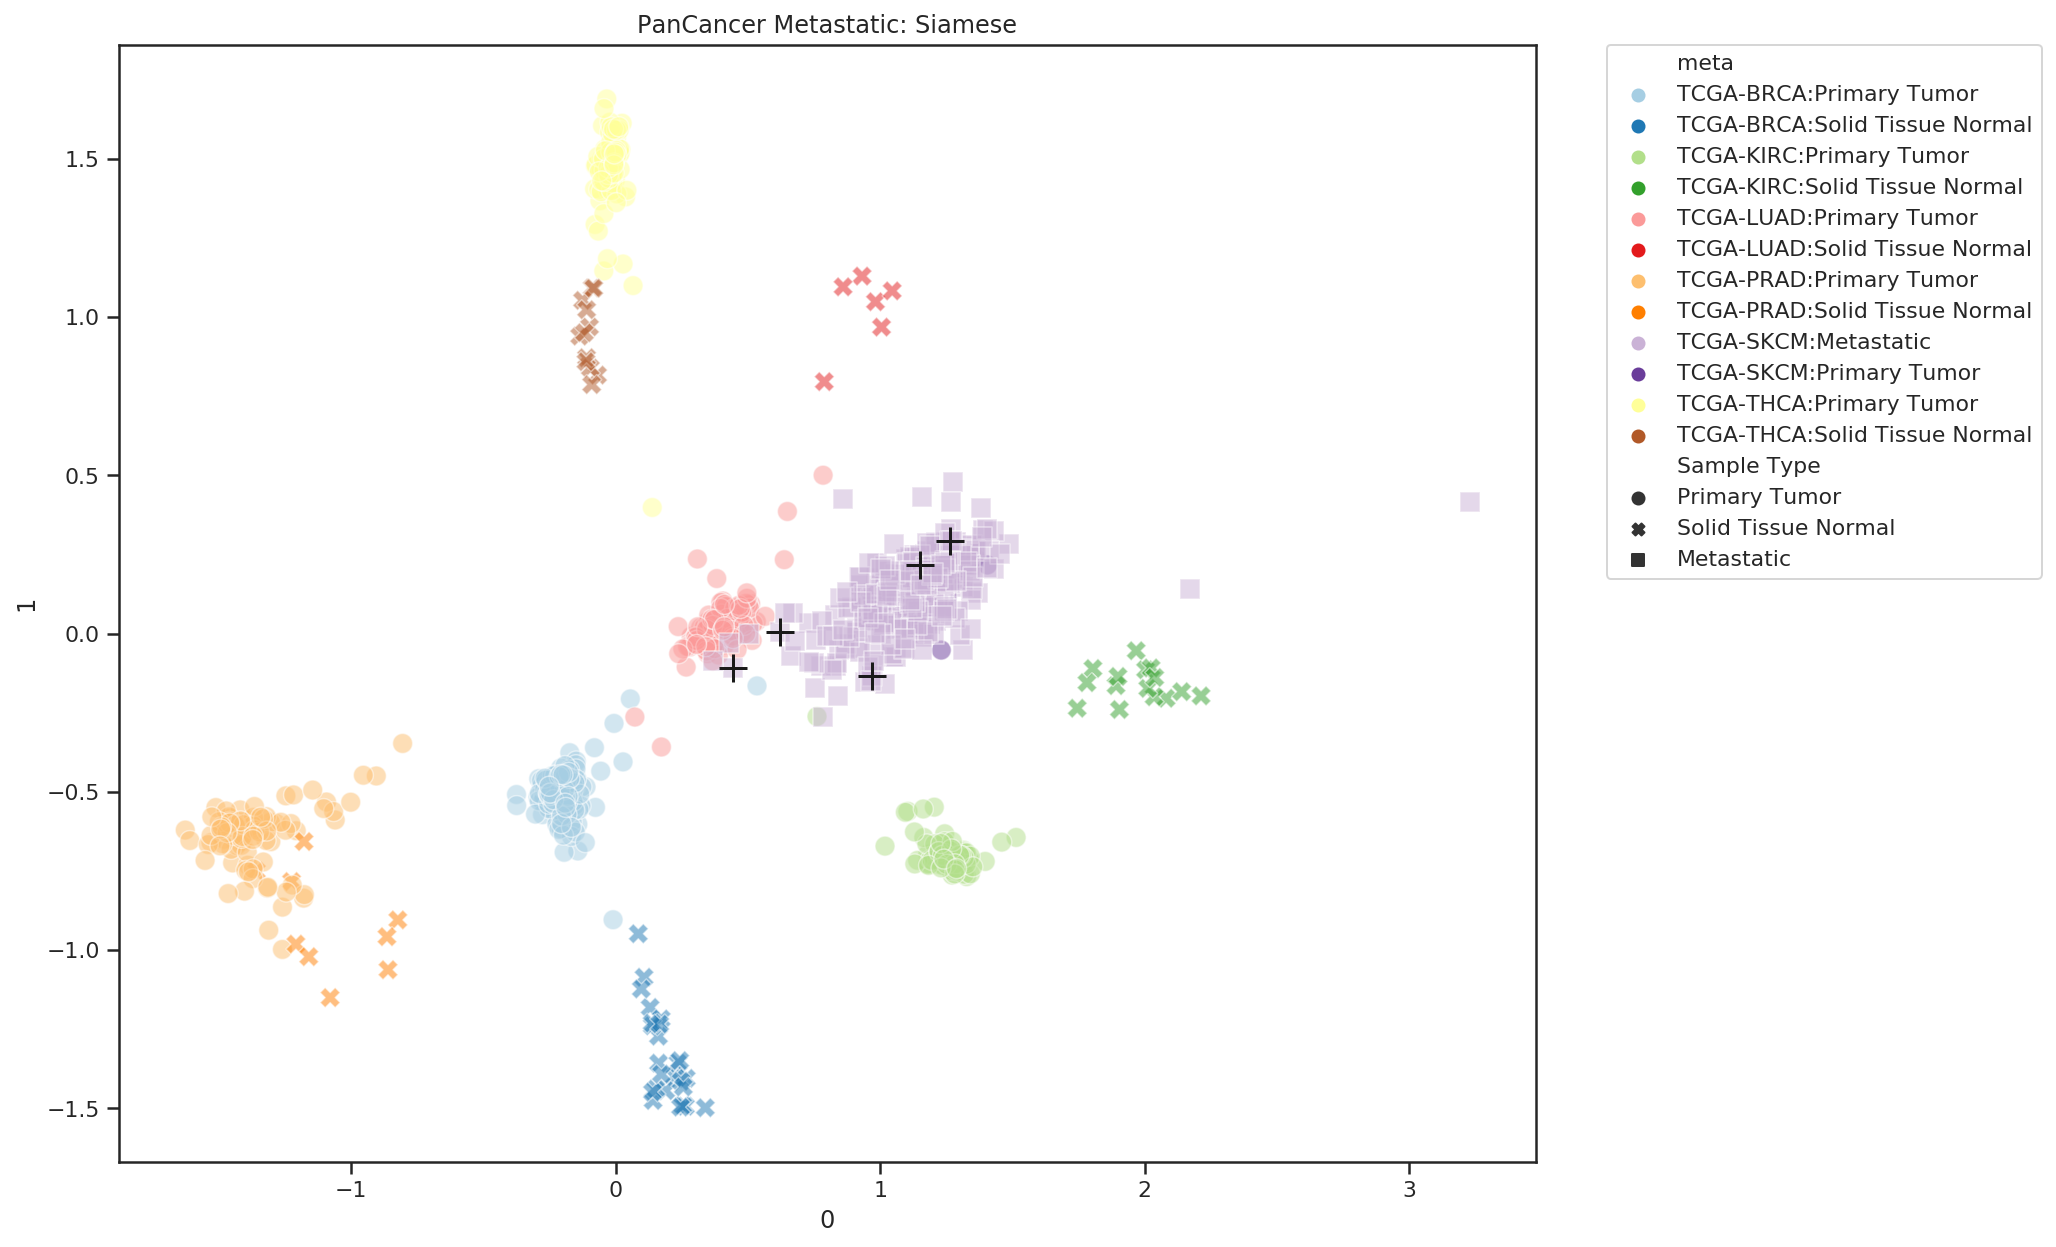

In [137]:
vis.sns_plot_embeddings(comb_embeddings, comb_labels, exp.meta_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.scatter(proj_embeddings_baseline[bool_skcm_metas_dist,0], 
            proj_embeddings_baseline[bool_skcm_metas_dist,1],
            marker="+", color='k', s=200)
plt.title('PanCancer Metastatic: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)